In [1]:
import os
from bs4 import BeautifulSoup
from tqdm import tqdm
import csv 
import cv2
import numpy as np

filename = "000002134416000050_a2015123110-k-t50"
filenames = [filename.split('.')[0] for filename in os.listdir('train_label')]

def rows_count(bs4_text):
    return len(bs4_text.find_all('tr'))

def column_count(bs4_text):
    column_counts = []
    for tr in bs4_text.find_all('tr'):
        column_counts.append(len(tr.find_all('td')))
    return max(column_counts)

def total_cells_count(bs4_text):
    return len(bs4_text.find_all('td')) 

def aspect_ratio_count(bs4_text):
    size = bs4_text.find('size')
    width = float(size.find('width').text)
    height = float(size.find('height').text)
    return width/height

with open('spanning.csv', 'w') as f:
    csvwriter = csv.writer(f, delimiter=',')
    csvwriter.writerow(['filename','spanning_pct','rows_count','column_count','total_cells','aspect_ratio','width_added', 'height_added'])
    destination_folder = "square_train_images"
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        
    for filename in tqdm(filenames):
        img_filename = 'train_images/' + filename + ".png"
        label_filename = 'train_label/' + filename + ".xml"
        dst_filename = 'square_train_images/' + filename + ".png"

        img=cv2.imread(img_filename)
        height, width, channel = img.shape

        new_length = max(height, width)
        new_img = np.full((new_length, new_length, channel), (255, 255, 255), dtype=np.uint)
        x_center = (new_length - width) // 2
        y_center = (new_length - height) // 2

        # copy img image into center of result image
        new_img[y_center:y_center+height, 
            x_center:x_center+width] = img

        cv2.imwrite(dst_filename, new_img)   

        with open(label_filename, 'r') as file:
            text = file.read()
            bs4_text = BeautifulSoup(text, 'lxml')
            total_td = len(bs4_text.find_all('td'))
            total_spanning = 0
            for td in bs4_text.find_all(['td','th']):
                try:
                    total_spanning += int(td['colspan']) - 1
                    total_spanning += int(td['rowspan']) - 1
                except:
                    pass
            spanning_pct = total_spanning / (total_spanning + total_td)
            csvwriter.writerow([filename, spanning_pct, rows_count(bs4_text), column_count(bs4_text),total_cells_count(bs4_text),aspect_ratio_count(bs4_text), x_center, y_center])

100%|██████████| 586/586 [03:02<00:00,  3.20it/s]


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('spanning.csv', header=0)
df

,filename,spanning_pct,rows_count,column_count,total_cells,aspect_ratio,width_added,height_added
0,000003799615000064_f0930201510-q-t7,0.444444,27,9,135,1.339503,0,321
1,000002134416000050_a2015123110-k-t79,0.133333,6,5,26,4.956947,0,1011
2,000007085816000166_bac-331201610xq-t649,0.400000,5,9,27,5.692135,0,1044
3,000007085816000166_bac-331201610xq-t248,0.373333,30,5,94,1.185861,0,198
4,000002134416000050_a2015123110-k-t46,0.369048,12,7,53,2.792723,0,813
...,...,...,...,...,...,...,...,...
581,000002134416000050_a2015123110-k-t198,0.300000,8,5,28,3.927132,0,944
582,000007085816000166_bac-331201610xq-t448,0.433333,10,9,51,3.074029,0,854
583,000007085816000166_bac-331201610xq-t90,0.291188,29,9,185,1.223671,0,231
584,000007085816000166_bac-331201610xq-t78,0.385714,10,7,43,3.272610,0,879


0.3653413028413028


<Figure size 640x480 with 0 Axes>

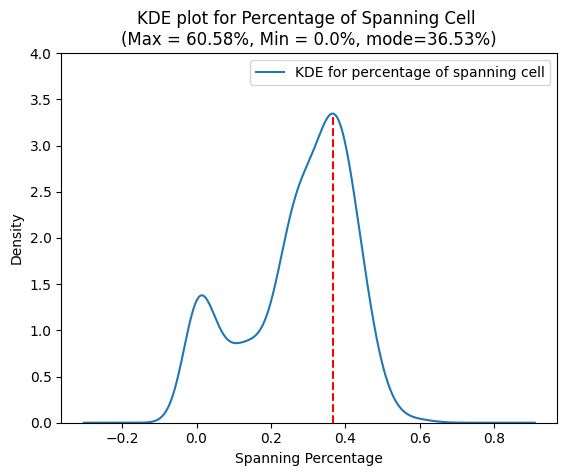

<Figure size 640x480 with 0 Axes>

In [4]:
ax = df['spanning_pct'].plot.kde()
data = np.array(ax.lines[0].get_data())

print(data[0][np.argmax(data[1])])
plt.title("KDE plot for Percentage of Spanning Cell \n(Max = {}%, Min = {}%, mode={}%)".format(round(max(df['spanning_pct']), 4) *100, round(min(df['spanning_pct']), 4)*100, np.round(data[0][np.argmax(data[1])], 4)*100))
plt.plot([data[0][np.argmax(data[1])], data[0][np.argmax(data[1])]],[0, np.max(data[1])], 'r--')
plt.xlabel('Spanning Percentage')
plt.legend(['KDE for percentage of spanning cell'])
plt.ylim([0,4])
plt.figure()

8.15915915915916


<Figure size 640x480 with 0 Axes>

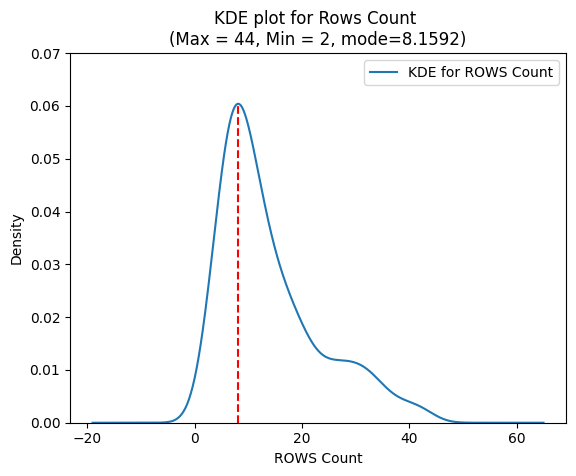

<Figure size 640x480 with 0 Axes>

In [4]:
ax = df['rows_count'].plot.kde()
data = np.array(ax.lines[0].get_data())

print(data[0][np.argmax(data[1])])
plt.title("KDE plot for Rows Count \n(Max = {}, Min = {}, mode={})".format(round(max(df['rows_count']), 4), round(min(df['rows_count']), 4), np.round(data[0][np.argmax(data[1])], 4)))
plt.plot([data[0][np.argmax(data[1])], data[0][np.argmax(data[1])]],[0, np.max(data[1])], 'r--')
plt.xlabel('ROWS Count')
plt.legend(['KDE for ROWS Count'])
plt.ylim([0,0.07])
plt.figure()

[Text(1, 0, 'Rows Count')]

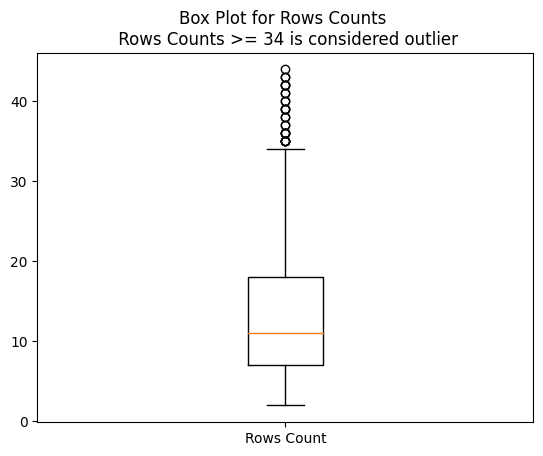

In [5]:
ax = plt.boxplot(df['rows_count'])
caps = [item.get_ydata()[0] for item in ax['caps']]
plt.title(f"Box Plot for Rows Counts \n Rows Counts >= {caps[1]} is considered outlier")
plt.gca().set_xticklabels(['Rows Count'])

6.155655655655657


<Figure size 640x480 with 0 Axes>

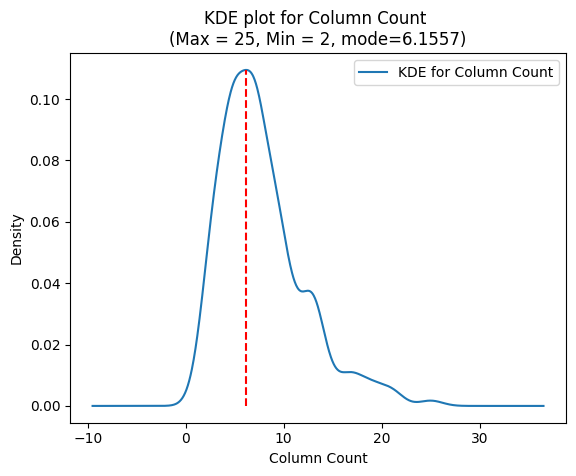

<Figure size 640x480 with 0 Axes>

In [6]:
ax = df['column_count'].plot.kde()
data = np.array(ax.lines[0].get_data())

print(data[0][np.argmax(data[1])])
plt.title("KDE plot for Column Count \n(Max = {}, Min = {}, mode={})".format(round(max(df['column_count']), 4), round(min(df['column_count']), 4), np.round(data[0][np.argmax(data[1])], 4)))
plt.plot([data[0][np.argmax(data[1])], data[0][np.argmax(data[1])]],[0, np.max(data[1])], 'r--')
plt.xlabel('Column Count')
plt.legend(['KDE for Column Count'])
# plt.ylim([0,0.07])
plt.figure()

[Text(1, 0, 'Column Count')]

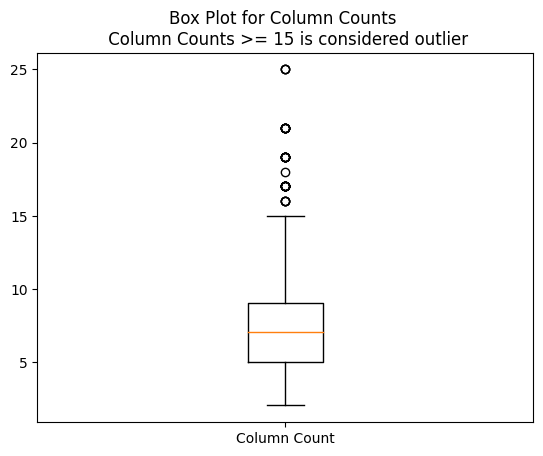

In [7]:
ax = plt.boxplot(df['column_count'])
caps = [item.get_ydata()[0] for item in ax['caps']]
plt.title(f"Box Plot for Column Counts \n Column Counts >= {caps[1]} is considered outlier")
plt.gca().set_xticklabels(['Column Count'])

1.8446805134627464


<Figure size 640x480 with 0 Axes>

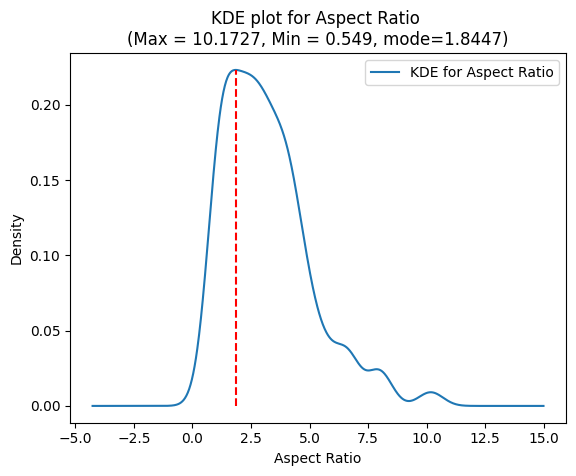

<Figure size 640x480 with 0 Axes>

In [8]:
ax = df['aspect_ratio'].plot.kde()
data = np.array(ax.lines[0].get_data())

print(data[0][np.argmax(data[1])])
plt.title("KDE plot for Aspect Ratio \n(Max = {}, Min = {}, mode={})".format(round(max(df['aspect_ratio']), 4), round(min(df['aspect_ratio']), 4), np.round(data[0][np.argmax(data[1])], 4)))
plt.plot([data[0][np.argmax(data[1])], data[0][np.argmax(data[1])]],[0, np.max(data[1])], 'r--')
plt.xlabel('Aspect Ratio')
plt.legend(['KDE for Aspect Ratio'])
# plt.ylim([0,0.07])
plt.figure()

[Text(1, 0, 'Aspect Ratio')]

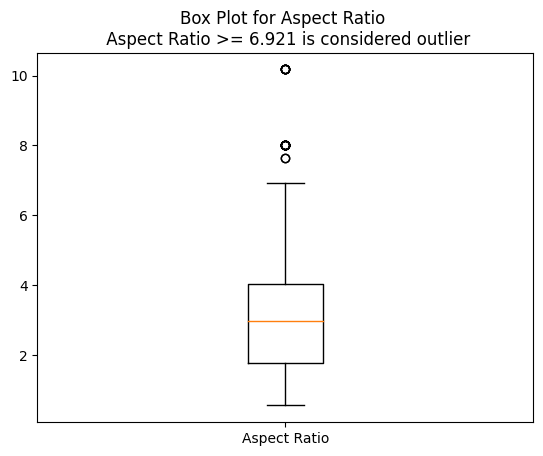

In [9]:
ax = plt.boxplot(df['aspect_ratio'])
caps = [item.get_ydata()[0] for item in ax['caps']]
plt.title(f"Box Plot for Aspect Ratio \n Aspect Ratio >= {round(caps[1], 3)} is considered outlier")
plt.gca().set_xticklabels(['Aspect Ratio'])

For case of Aspect Ratio, instead of removing images using aspect ratio greater than 6.921, we simply add padding on either left, right or top, bottom to make the square image, and then make the image shape **square**.

In [10]:
df_Copy = df.copy()
df_Copy

,filename,spanning_pct,rows_count,column_count,total_cells,aspect_ratio,width_added,height_added
0,000003799615000064_f0930201510-q-t7,0.444444,27,9,135,1.339503,0,321
1,000002134416000050_a2015123110-k-t79,0.133333,6,5,26,4.956947,0,1011
2,000007085816000166_bac-331201610xq-t649,0.400000,5,9,27,5.692135,0,1044
3,000007085816000166_bac-331201610xq-t248,0.373333,30,5,94,1.185861,0,198
4,000002134416000050_a2015123110-k-t46,0.369048,12,7,53,2.792723,0,813
...,...,...,...,...,...,...,...,...
581,000002134416000050_a2015123110-k-t198,0.300000,8,5,28,3.927132,0,944
582,000007085816000166_bac-331201610xq-t448,0.433333,10,9,51,3.074029,0,854
583,000007085816000166_bac-331201610xq-t90,0.291188,29,9,185,1.223671,0,231
584,000007085816000166_bac-331201610xq-t78,0.385714,10,7,43,3.272610,0,879


In [11]:
boolean_mask = (df_Copy['rows_count'] < 34) & (df_Copy['column_count'] < 15)
boolean_mask.value_counts()

True     522
False     64
dtype: int64

In [12]:
df_Copy[boolean_mask]

,filename,spanning_pct,rows_count,column_count,total_cells,aspect_ratio,width_added,height_added
0,000003799615000064_f0930201510-q-t7,0.444444,27,9,135,1.339503,0,321
1,000002134416000050_a2015123110-k-t79,0.133333,6,5,26,4.956947,0,1011
2,000007085816000166_bac-331201610xq-t649,0.400000,5,9,27,5.692135,0,1044
3,000007085816000166_bac-331201610xq-t248,0.373333,30,5,94,1.185861,0,198
4,000002134416000050_a2015123110-k-t46,0.369048,12,7,53,2.792723,0,813
...,...,...,...,...,...,...,...,...
581,000002134416000050_a2015123110-k-t198,0.300000,8,5,28,3.927132,0,944
582,000007085816000166_bac-331201610xq-t448,0.433333,10,9,51,3.074029,0,854
583,000007085816000166_bac-331201610xq-t90,0.291188,29,9,185,1.223671,0,231
584,000007085816000166_bac-331201610xq-t78,0.385714,10,7,43,3.272610,0,879
